## Assessment: Classification of Reaction data

This is an assessment that forms part of the ML for Chemistry workshop for Advanced Topics in Physical Chemistry. 

### What can/cannot be used for this coursework?
**Using Google** to find programmatic solutions to a problem is perfectly acceptable, however if you copy more than a single line of code from an online source make sure you indicate this in the following way with a comment in Python:

```python
# The following xxx lines follow a solution found here
# https://stackoverflow.com/questions/39324039/highlight-typos-in-the-jupyter-notebook-markdown on 20/10/2021
```

What you **shouldn't have** have to do is:
- Install additional packages in your Noteable environment
- Use code you do not understand found on the web

What is clearly **not allowed**:
<div class="alert alert-danger">
    You are NOT allowed to send/give/receive Python code to/from classmates and others.
The standard examination rules apply to this project.
</div>

The course will be marked by hand, but will be checked both manually as well as through turn-it-in for plagiarism.

### How is the coursework assessed:

Think of this as a guided lab report in the form of a Jupyter notebook with an introduction section exploring the data, two sections on doing the classification problems using Random Forests and a Neural network, and a final section with conclusions and discussions. A skeleton structure for the report is provided in the cells below. 

- Each part of your code should run.
- Every function you write should have an appropriate doc-string.
- All plots should be labelled correctly and all fonts should have a legible size.
- Write an introduction, a discussion, and a conclusion section in markdown. Use references where appropriate. 
- Remember you can use LaTeX in markdown by using $$ to start a maths environment. 

Overall criteria:
- 10 % Code presentation and readability
- 20 % Production quality (plots, etc.)
- 50 % Report structure and readability
- 20 % Data interpretation and conclusion

**The assessment is worth 20% of the overall module mark.**   

**Deadline: 10th March 2023 5pm**   

<div class="alert alert-success">
Reminder: Comment your code, use markdown to explain your working where appropriate, and make sure all your variable names are sensible! Also make sure to choose appropriate levels of significant figures for print out and make sure you use the correct units. 
</div>

## The Data
You will be working with the `QMrxn20: Thousands of reactants and transition states for competing E2 and SN2 reactions` dataset. The whole dataset can be found here: [https://archive.materialscloud.org/record/2020.55](https://archive.materialscloud.org/record/2020.55). It is a dataset of SN2 and E2 reactions with reactant, product, and transition state coordinates. 

The task:
- Use xyz coordinates to classify geometries as forming a transition state geometry (1) and another geometry (0)
- Use a Random Forest as a classifier similar to the one in Unit 2 for this task
- Use a neural network similar to the one in Unit 3 for this task

The file `dataset.csv` contains the prerocessed data for these tasks from the original dataset. In this dataset coordinates and information on energies etc have been already combined, and the data has been subsampled down to ~80k datapoints.

The structure of the dataset looks as follows:

```
label,reaction,geometry,number,energy,method,element_0, element_0,x coordinates_0,y coordinates_0,z coordinates_0,element_1,...,z_coordinates_20
A_A_A_A_A_A,e2,ts,0,transition-states/e2/A_A_A_A_A_A.xyz,-179.132058577095,mp2,C,-0.04447,-0.0119,-0.3780,C,...,-0.153736
A_A_A_A_B_A,e2,ts,0,-539.161015594451,mp2,F,-0.044,-0.011,-0.3780,C,-0.1537 
```

You find the label for the data in the column named geometry. If it is `ts`, i.e. a transition state, the label should be 1, if it is anything else the label should be 0. You will need to prepare the label in such a way that you can train on it. Columns 7 to the end contain the x,y,z coordinates. Train on the coordinates, but be careful not to include the element names as well! 

### External references
**Journal reference**
G. F. von Rudorff, S. N. Heinen, M. Bragato, O. A. von Lilienfeld, Machine Learning: Science and Technology 1, 045026 (2020). doi:10.1088/2632-2153/aba822

**Preprint (Preprint where the data generation is discussed)**
G. F. von Rudorff, S. N. Heinen, M. Bragato, O. A. von Lilienfeld, arXiv:2006.00504

------

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import pandas as pd
import time

## Start of the Report

Please leave the header sections as you find them, but feel free to add as many cells in each section as you need to answer them. 

## 1. Introduction and exploring the data

In the directory `data` you will find a file called `dataset.csv`. Freely explore the dataset in this section.

Things you definitely need:

- an **array of labels** which you can extract from the column geometries (1-ts, 0-everything else)
- an **array of x, y, and z coordinates** for all elements. 

Some of the coordinates will be 0 because the molecule has less than 21 atoms. Please explore some statistics around the data. 

In this part of your submission notebook you should also introduce what a classification problem is, and this dataset in particular.

### Importing the data

The pandas library was used to import the raw data:

In [2]:
# Load data as a pandas dataframe. This will allow us to obtain the desired arrays. 

df=pd.read_csv("data/dataset.csv")

df

/tmp/ipykernel_178/3907693696.py:3: DtypeWarning: Columns (74,78,82,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("data/dataset.csv")


,label,reaction,geometry,number,energy,method,element_0,x coordinates_0,y coordinates_0,z coordinates_0,...,y coordinates_18,z coordinates_18,element_19,x coordinates_19,y coordinates_19,z coordinates_19,element_20,x coordinates_20,y coordinates_20,z coordinates_20
0,A_A_A_A_A_A,e2,ts,0,-179.132059,mp2,C,-0.044472,-0.011945,-0.378067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A_A_A_A_C_A,e2,ts,0,-2652.360662,mp2,C,-0.157149,0.002342,-0.370737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A_A_A_C_B_C,e2,ts,0,-1090.478159,mp2,C,-0.103842,-0.000232,-0.417914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A_A_A_D_B_C,e2,ts,0,-1037.585093,mp2,C,-0.348840,0.051602,-0.273416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A_A_A_E_B_A,e2,ts,0,-594.392336,mp2,C,-0.061746,0.050678,-0.424045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81565,E_E_C_C_B_B,sn2,rcu,18,-931.237677,hf,C,-0.537452,-0.051456,-1.456212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81566,E_E_D_D_A_A,sn2,rcu,0,-368.061328,mp2,C,-0.438902,-0.000059,-1.530075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81567,E_E_D_D_A_A,sn2,rcu,7,-368.328083,lccsd,C,-0.413479,-0.002606,-1.520018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81568,E_E_D_D_A_A,sn2,rcu,12,-366.795817,hf,C,-0.155387,0.022518,-1.621509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploring the data

Number of e2 and sn2 reactions stored in the data:

In [3]:
l_react=list(df['reaction'].to_numpy())

print('The number of e2 reactions present is ' + str(l_react.count('e2')))
print('The number of sn2 reactions present is ' + str(l_react.count('sn2')))
print('The number of unspecified reactions is ' + str(l_react.count('-')))


The number of e2 reactions present is 39004
The number of sn2 reactions present is 31767
The number of unspecified reactions is 10799


Number of transition states, reactants and products:

In [4]:
#convert geometry column to an array
geo_array=df['geometry'].to_numpy()

geo_types=np.zeros(len(geo_array)) 

for n in range(len(geo_array)):
    if geo_array[n]=='ts': 
        geo_types[n]=1 #transition state 
        
    elif geo_array[n]=='rcu' or geo_array[n]=='r' or geo_array[n]=='rcc': 
        geo_types[n]=0 #reactant
        
    else:
        geo_types[n]=2 #product

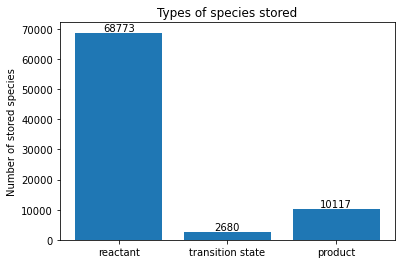

In [5]:
"""
code for bar chart taken from 
https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html on 13/03/2023
"""
n_r=list(geo_types).count(0)
n_t=list(geo_types).count(1)
n_p=list(geo_types).count(2)

species_names = ['reactant', 'transition state', 'product']
species_counts = [n_r, n_t, n_p]

fig, ax = plt.subplots()
bar_container = ax.bar(species_names, species_counts)
ax.set(ylabel='Number of stored species', title='Types of species stored')
ax.bar_label(bar_container)
fig.show()

As can be seen from the figure above, only 3.28 % of the stored species are transition states. This suggests that most of our predicted labels for the binary RF classifier (see section 2) will be 0 (non-transition state).

Extracting array of labels and atom geometries:

In [6]:
#convert geometry column to an array
geo_array=df['geometry'].to_numpy()

geo_index=np.zeros(len(geo_array)) #set NaN values to 0

for n in range(len(geo_array)):
    if geo_array[n]=='ts': #if transition state present, set element to 1
        geo_index[n]=1

print(geo_array) #sanity check
print(geo_index)    

['ts' 'ts' 'ts' ... 'rcu' 'rcu' 'rcu']
[1. 1. 1. ... 0. 0. 0.]


In [7]:
df_coord=df.copy() #create copy of original data to extract x,y,z coordinates

df_coord.drop(columns=['label', 'reaction', 'geometry', 'number', 'energy', 'method'], inplace=True) 

for n in range(21):
    column_name="element_" + str(n)
    df_coord.drop(columns=[column_name], inplace=True) #remove element names

xyz=df_coord.to_numpy() #convert to an array of x,y,z coordinates
xyz=np.nan_to_num(xyz, nan=0.0) #replace NaN with 0.0

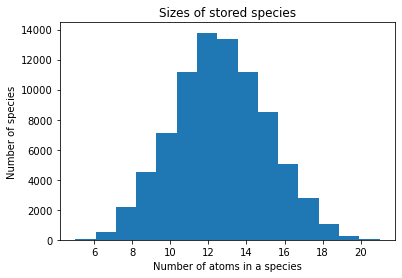

In [8]:
n_atoms=[]

for i in range(len(xyz)):
    n=np.count_nonzero(xyz[i])
    n_atoms.append(int(n/3))
  
plt.title('Sizes of stored species')
plt.ylabel('Number of species')
plt.xlabel('Number of atoms in a species')
plt.hist(n_atoms, bins=15)
plt.show()

### What is a classification problem?

In the field of machine learning, a classification problem refers to a task where a trained model predicts a class label given certain input data. Classification problems can be found in a variety of applications, such as in facial recognition, image classification and fraud detection. In this assessment, the input data refers to a set of coordinates for the constituent atoms of a given species. A ML model then predicts whether the input data describes a transition state or a non-transition state. The neural network discussed in part 3 can also differentiate between products and reactants.

## 2. Classify the reaction data into reactant, transition state, and product using a Random Forests

Here you will use your labels and x,y,z coordinates to train a Random Forests classifier to identify transition states from non-transition states. You may need to set NaN coordinate entries to 0 for this to work.

Using the sklearn library, the arrays of labels and xyz coordinates were split into training and testing sets, with 80% of the data being used for training, and the other 20% being used for testing:

In [9]:
# Split data into test and training sets

from sklearn.model_selection import train_test_split

xyz_train, xyz_test, geo_train, geo_test=train_test_split(xyz, geo_index, test_size=0.20)

In [11]:
print(xyz_train.shape)
print(geo_train.shape)
print(xyz_test.shape)
print(geo_test.shape)

(65256, 63)
(65256,)
(16314, 63)
(16314,)


We can now set up a RandomForest classifier model, and train the model using the previously assembled training set of coordinates:

In [10]:
from sklearn.ensemble import RandomForestClassifier

#RF=RandomForestClassifier(n_estimators=25)
#RF.fit(xyz_train, geo_train)

We now define a function to indicate the success of our model (code based on ML workshop 2):

In [11]:
def RF_success(RF, test_data, test_labels):
    """
    Returns the success rate of a given RF binary classifier based on 
    its performance in predicting the outcomes of the supplied test set.
    
    :param RF: RandomForestClassifier model
    :param test_data: array of test data
    :param test_labels: binary array of outcomes for the test dataset
    :return: percentage success of the RF model
    """    
    r = RF.predict(test_data)
    success = np.sum((r-test_labels)==0)
    percent = float(success)/len(test_labels)*100
    
    return percent

A key parameter in a RF model is the number of trees, or classifiers. A larger number of trees implies greater success, but also incurs the cost of extra computation. We can vary the number of trees while using the same test and train datasets to estimate the minimum number of estimators required for a satisfactory level of success:

In [14]:
data_list=[]
n_trees=[]
times=[]

for n in range(5, 50):
    
    xyz_train, xyz_test, geo_train, geo_test=train_test_split(xyz, geo_index, test_size=0.20)
       
    start_time = time.time() #start timer
    
    RF=RandomForestClassifier(n_estimators=n) #reinitialise the RF classifier
    RF.fit(xyz_train, geo_train)
    
    t=(time.time() - start_time) #end timer
    
    success=RF_success(RF, xyz_test, geo_test)

    data_list.append(success)
    n_trees.append(n)
    times.append(t)  

data_array=np.array(data_list)
RF_estimators=pd.DataFrame(data_array, index=None, columns=np.array(['Accuracy (%)']))
RF_estimators['Number of trees']=np.array(n_trees)
RF_estimators['Accuracy (%)']=data_array
RF_estimators['Runtime (s)']=np.array(times)

In [ ]:
RF_estimators.head()

n_estimators=25 was chosen, and the model was initialised, trained and tested 50 times:

In [19]:
data_list=[]

for i in range(50):

    xyz_train, xyz_test, geo_train, geo_test=train_test_split(xyz, geo_index, test_size=0.20)

    RF_model=RandomForestClassifier(n_estimators=25)
    RF_model.fit(xyz_train, geo_train)

    percent=RF_success(RF_model, xyz_test, geo_test)

    data_list.append(percent)

data_array=np.array(data_list)
df_RF=pd.DataFrame(data_array, index=None, columns=np.array(['Accuracy (%)']))

In [22]:
df_RF.head()

,Accuracy (%)
0,99.981611
1,100.000000
2,99.981611
3,99.975481
4,100.000000


Using our 50 simulations, we can calculate the average success percentage of our model:

In [26]:
av_accuracy=np.average(df_RF['Accuracy (%)'].to_numpy())
av_accuracy

99.98908912590414

In [24]:
error=(np.std(df_RF['Accuracy (%)'].to_numpy()))/np.sqrt(50)
error

0.0011538181749028

<div class="alert alert-info">
    <b>Key result:</b>  

Calculated accuracy of our RandomForest classifier model: 

$success=99.9891(12) \ \%$
    
<div>


In [12]:
from sklearn.metrics import confusion_matrix, roc_curve,auc

Section 4 discusses the behaviour of our RF model in more detail, as well as discussing the resulting confusion matrix and ROC curve.

## 3. Classify the reaction data into reactant, transition state, and product using a Neural Network

Use the same data as before, but now set up a neural network using PyTorch for this classification task. Train the network and use appropriate plots to show your results. 

### Generating training and testing data

In [13]:
#test for what types of geometry labels are present

print(set(df['geometry'].to_numpy()))

{'r', 'pc', 'ts', 'rcu', 'rcc'}


String labels present:

  - ts  =  Transition state
  - r   =  Reactant conformers
  - rcc  =  Reactant complex constrained conformers
  - rcu  =  Reactant complex unconstrained conformers
  - pc  =  Product conformers
  
We want to create an array of indices for products, reactants and transition states:

In [14]:
#convert geometry column to an array
geo_array=df['geometry'].to_numpy()

geo_types=np.zeros(len(geo_array)) #set NaN values to 0

for n in range(len(geo_array)):
    if geo_array[n]=='ts': 
        geo_types[n]=1 #transition state 
        
    elif geo_array[n]=='rcu' or geo_array[n]=='r' or geo_array[n]=='rcc': 
        geo_types[n]=0 #reactant
        
    else:
        geo_types[n]=2 #product

Indices: 

- 0 = reactant
- 1 = transition state
- 2 = product

In [15]:
print(np.shape(xyz))
print(np.shape(geo_types))

(81570, 63)
(81570,)


In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

From now one, use variable names X and Y for ease. X refers to the xyz coordinate input data, whereas Y refers to the output indices (0,1,2).

In [17]:
Y=torch.tensor(geo_types, dtype=torch.float32)
X=torch.tensor(xyz, dtype=torch.float32)

print(X.dtype)
print(Y.dtype)

torch.float32
torch.float32


In [18]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Split the train data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

Y_train = Y_train.type(torch.LongTensor)
Y_test = Y_test.type(torch.LongTensor)

print(len(X_test))
print(len(X_train))

16314
52204


Create dataloaders for the test and train data:

In [19]:
dataset_test = TensorDataset(X_test, Y_test)
dataloader_test  =  DataLoader(dataset_test, batch_size=100, shuffle=True)

In [20]:
dataset_train = TensorDataset(X_train, Y_train)
dataloader_train  =  DataLoader(dataset_train, batch_size=256, shuffle=True)

In [21]:
for i,data in enumerate(dataloader_train):
    xtrain      = data[0]     
    ytrain      = data[1]                    # train labels
    ytrain = ytrain.type(torch.LongTensor)

for i,data in enumerate(dataloader_test):      
    xtest        = data[0]     
    xtest_conv   = data[0]                 
    ytest=data[1]                           # test labels
    ytest = ytest.type(torch.LongTensor)

### Assembling the neural network

When building the neural network, a similar structure to the one used in the pytorch ML workshop is used.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class NN(nn.Module):    # this class inherits from nn.Module
    def __init__(self, sample_size):
        super(NN, self).__init__() #this calls the constructor of the parent class nn.Module
        
        # define network layers
        self.fc1 = nn.Linear(sample_size, 40)   # nn.Linear used as constructor arguments
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 3)    # we want a final output of 3 (indices 0,1,2 possible as output)
        torch.manual_seed(4)           # generating numbers changes the state of the random number generator.
                                       # we thus have to set the seed back
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Our input xyz array has 63 columns, therefore use a sample size of 63 when initialising the network.

In [24]:
net = NN(63) #sample_size=63

In [25]:
import torch.optim as optim

In [26]:
# function taken from ML workshop 3

def class_accuracy(output,y):
    '''If np.argmax(out,axis=1)-y is non-zero, i.e. label y is 9 and prediction is 5 then 
       diff is incremented by 1, i.e. every time there is a mismatch between prediction and label.
       The ratio diff/np.size(y) gives us the ratio of false predictions over the total number of datapoints.
       One minus that gives the model accuracy.
    '''
    output = output.cpu().detach().numpy()    # no need for the .cpu() here as we are working with cpu tensors
    y      = y.cpu().detach().numpy()
    diff   = np.count_nonzero(np.argmax(output,axis=1)-y) # np.argmax returns the index/indices of max value(s)
                                                        # along specified axis
    return (1-(diff/np.size(y)))*100

In [27]:
net

NN(
  (fc1): Linear(in_features=63, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=3, bias=True)
)

### Training the model

Two key factors when training our model are the number of epochs and the learning rate, lr. We will vary both of these parameters to find achieve optimal results. The reasoning behind the resulting choice for num_epochs and lr can be found in section 4.

We start by tracking the accuracy and loss over 250 epochs:

In [98]:
num_epochs = 250
data_list=[]

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=5*10**-3, momentum=0.9)

for epoch in range(num_epochs): 
    for i,data in enumerate(dataloader_train):
        # Load in the training datapoints
        x=data[0]                 
        y=data[1]   
        optimizer.zero_grad()
        output = net(x)
        loss = criterion(output,y) 
        loss.backward()
        optimizer.step()
                   
        if epoch % 10 == 0 and i==0:
            # evety 100 epochs after the first batch 
            acc        = class_accuracy(output,y)
            outputtest = net(xtest)
            loss_test  = criterion(outputtest,ytest)
            acc_test   = class_accuracy(outputtest,ytest)
            # print(f'epoch {epoch}/{num_epochs}, accuracy train {acc:.2f} %, loss train, {loss.item():.5f}, accuracy test {acc_test:.2f} %, loss test, {loss_test.item():.5f}')
            
            d=np.array([acc, loss.item(), acc_test, loss_test.item()])
            data_list.append(d)

data_array=np.array(data_list)
df_epochs=pd.DataFrame(data_array, index=None, columns=np.array(['Accuracy train', 'Loss train', 'Accuracy test', 'Loss test']))

#df.to_excel("data.xlsx")
            

In [101]:
df_epochs.head()

,Accuracy train,Loss train,Accuracy test,Loss test
0,36.328125,1.066499,42.857143,1.053800
1,87.500000,0.287421,92.857143,0.201123
2,87.109375,0.240552,85.714286,0.166677
3,87.890625,0.238001,92.857143,0.138031
4,85.937500,0.244481,92.857143,0.101289


Using 10 epochs for training, the learning rate is varied between 0.01 and 5E-4 to maximise the predictive accuracy.

In [ ]:
num_epochs = 11
data_list=[]

for n in range(21):

    net = NN(63)
    net

    criterion = nn.CrossEntropyLoss()
    
    learning_rate=5E-4+(4.75E-4*n)

    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs): 
        for i,data in enumerate(dataloader_train):
            # Load in the training datapoints
            x=data[0]                 
            y=data[1]   
            optimizer.zero_grad()
            output = net(x)
            loss = criterion(output,y) 
            loss.backward()
            optimizer.step()

    acc        = class_accuracy(output,y)
    outputtest = net(xtest)
    loss_test  = criterion(outputtest,ytest)
    acc_test   = class_accuracy(outputtest,ytest)
    #print(f'epoch {epoch}/{num_epochs}, accuracy train {acc:.2f} %, loss train, {loss.item():.5f}, accuracy test {acc_test:.2f} %, loss test, {loss_test.item():.5f}')

    d=np.array([learning_rate, acc_test, loss_test.item()])
    data_list.append(d)
    
    #print('Run: ' + str(n) + '/20')
    
data_array=np.array(data_list)
df_lr=pd.DataFrame(data_array, index=None, columns=np.array(['Learning rate', 'Accuracy test', 'Loss test']))


In [ ]:
df_lr.head()

A learning rate of 5E-3 was chosen (see section 4 for justification).

### Testing the model

Using the chosen optimised parameters of num_epochs=16 and lr=5E-3, the Neural Network was trained and tested 51 times, as shown below:

In [ ]:
num_epochs = 16
data_list=[]

for n in range(51):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    # Split the train data into train and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

    Y_train = Y_train.type(torch.LongTensor)
    Y_test = Y_test.type(torch.LongTensor)

    dataset_test = TensorDataset(X_test, Y_test)
    dataloader_test  =  DataLoader(dataset_test, batch_size=100, shuffle=True)

    dataset_train = TensorDataset(X_train, Y_train)
    dataloader_train  =  DataLoader(dataset_train, batch_size=256, shuffle=True)
    
    for i,data in enumerate(dataloader_train):
        xtrain      = data[0]     
        ytrain      = data[1]                    # train labels
        ytrain = ytrain.type(torch.LongTensor)

    for i,data in enumerate(dataloader_test):      
        xtest        = data[0]     
        xtest_conv   = data[0]                 
        ytest=data[1]                           # test labels
        ytest = ytest.type(torch.LongTensor)

    net = NN(63)
    net

    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(net.parameters(), lr=5E-3, momentum=0.9)

    for epoch in range(num_epochs): 
        for i,data in enumerate(dataloader_train):
            # Load in the training datapoints
            x=data[0]                 
            y=data[1]   
            optimizer.zero_grad()
            output = net(x)
            loss = criterion(output,y) 
            loss.backward()
            optimizer.step()

    acc        = class_accuracy(output,y)
    outputtest = net(xtest)
    loss_test  = criterion(outputtest,ytest)
    acc_test   = class_accuracy(outputtest,ytest)
    #print(f'epoch {epoch}/{num_epochs}, accuracy train {acc:.2f} %, loss train, {loss.item():.5f}, accuracy test {acc_test:.2f} %, loss test, {loss_test.item():.5f}')

    d=np.array([acc_test, loss_test.item()])
    data_list.append(d)
    
    #print('Run: ' + str(n) + '/50')
    
data_array=np.array(data_list)
df_NN=pd.DataFrame(data_array, index=None, columns=np.array(['Accuracy test', 'Loss test']))


In [28]:
df_NN=pd.DataFrame(data_array, index=None, columns=np.array(['Accuracy test', 'Loss test']))

In [29]:
av_accuracy=np.average(df_NN['Accuracy test'].to_numpy())
av_accuracy

96.49859943977593

In [31]:
error=(np.std(df_NN['Accuracy test'].to_numpy()))/np.sqrt(50)
error

0.6442577030812323

In [32]:
av_loss=np.average(df_NN['Loss test'].to_numpy())
av_loss

0.07272084393223528

In [33]:
error_loss=(np.std(df_NN['Loss test'].to_numpy()))/np.sqrt(50)
error_loss

0.010127415099448834

<div class="alert alert-info">
    <b>Key result:</b>  

Calculated accuracy of our neural network classifier model: 

$success=96.5(6) \ \%$
    
Calculated loss:
   
$loss=0.073(10) \ \%$
    
<div>


## 4. Discussion of results and conclusion
In this part of your notebook you should discuss your results using Markdown text. 

### Random Forest

A RanfomForest binary classifier model based on the sklearn library was assembled. The number of trees in the RF model was varied between 5 and 49 to estimate a satisfactory number of classifiers, while minimising the computational effort. The runtime required for training was also calculated for the appropriate number of estimators being used. 

<AxesSubplot:title={'center':'RF predictive success as a function of the number of trees'}, xlabel='Number of trees', ylabel='Accuracy (%)'>

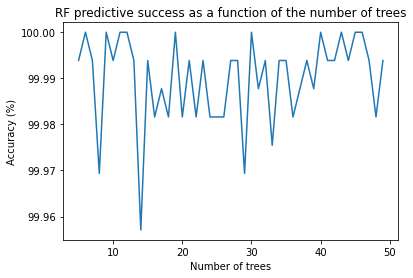

In [42]:
RF_estimators.plot(title='RF predictive success as a function of the number of trees', x='Number of trees', y='Accuracy (%)', ylabel='Accuracy (%)', legend=False)

<AxesSubplot:title={'center':'Training runtime vs number of trees'}, xlabel='Number of trees', ylabel='Training runtime (s)'>

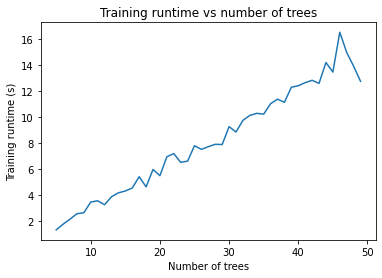

In [43]:
RF_estimators.plot(title='Training runtime vs number of trees', x='Number of trees', y='Runtime (s)', ylabel='Training runtime (s)', legend=False)

As can be seen in the figures above, increasing the number of trees/estimators in the RF model only very incrementally increases the accuracy of the model, as the success percentage is greater than 99.95 % for all the tested number of estimators. However, as a rule it is preferrable to have a larger number of estimators, as this is associated with generally higher predictive power. We can see that the training runtime increases approximately linearly with the number of estimators. To balance having both an adequate number of trees in the model, but also maintaining a lightweight training computation, **n_estimators=25** was chosen for the RF model. RandomForest as an algorithm does not overfit data, therefore we do not have to worry about having too many estimators.

The RF classifier model was initialised, trained and tested 50 times. We can therefore calculate the overall success rate of our model, by taking the average of these 50 runs. The error will be equal to the standard deviation divided by $\sqrt{50}$:

$success=99.9891(12) \ \%$



The success of the model can be further evaluated using an ROC curve and confusion matrix. The code for these two graphics was taken from the ML pytorch workshop.

In [44]:
xyz_train, xyz_test, geo_train, geo_test=train_test_split(xyz, geo_index, test_size=0.20)
RF=RandomForestClassifier(n_estimators=25)
RF.fit(xyz_train, geo_train)

RandomForestClassifier(n_estimators=25)

In [45]:
true_labels=geo_test
predictions=RF.predict(xyz_test)

In [47]:
from sklearn.metrics import confusion_matrix, roc_curve,auc

#### ROC curve

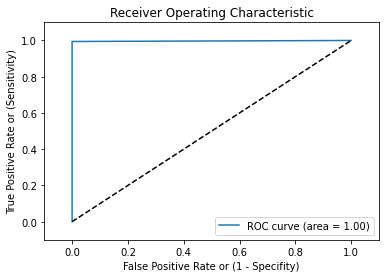

In [54]:
# ROC curve

fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The x-axis of the ROC graph represents the false positive rate, while the y-axis represents the true positive rate. 

$true \ positive \ rate = \frac{true \ positives}{true \ positives + false \ negatives}$

$false \ positive \ rate = \frac{false \ positives}{false \ positives + true \ negatives}$

- For a binary classifier, a perfect model will have an ROC curve area of 1.0, while a completely random (and hence useless) model will have an area of 0.5. 
- The ROC curve for our RandomForest model shows an area of 1.00, which is indicative of a perfect classifier. 
- This implies that our binary classifier is of very high quality.




#### Confusion matrix

<AxesSubplot:>

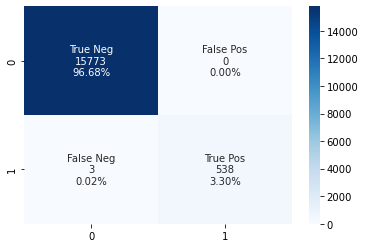

In [52]:
# Plot confusion matrix

cf_matrix= confusion_matrix(geo_test, RF.predict(xyz_test))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The confusion matrix further illustrates the high quality of our RF model, with 99.98 % of the test data having been predicted succesfully. Only 3 out of 16314 sets of coordinates were incorrectly predicted. Out of the correctly predicted species, 538 transition states were identified.

### Neural Network

The first key parameter to optimise is the number of epochs used in training. We want to have a sufficient number of epochs for high-quality prediction, but also want to avoid overfitting. Training of the neural network described in section 3 was carried out over 250 epochs, and the accuracy and loss during training was measured. During this process the learning rate was held constant at $5 \times 10^{-3}$.

<AxesSubplot:title={'center':'Accuracy during neural network training'}, xlabel='Number of epochs', ylabel='Accuracy (%)'>

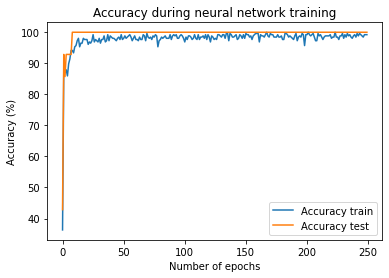

In [116]:
df_epochs.plot.line(title='Accuracy during neural network training', y=['Accuracy train', 'Accuracy test'], xlabel='Number of epochs', ylabel='Accuracy (%)')

<AxesSubplot:title={'center':'Loss during neural network training'}, xlabel='Number of epochs'>

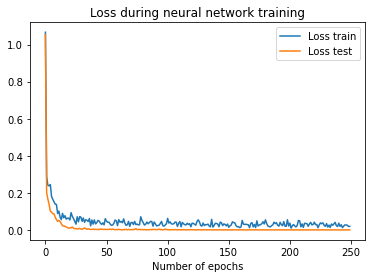

In [117]:
df_epochs.plot.line(title='Loss during neural network training', y=['Loss train', 'Loss test'], xlabel='Number of epochs')

As can be seen from these figures, 100% accuracy in the test set is achieved after 8 epochs, and a test loss of <0.02 is achieved after 16 epochs. After 16 epochs, the train accuracy is >96 %, and the train loss is <0.1. This implies that 16 epochs is a suitable number for training.

#### Learning rate

The learning rate was varied between 0.01 and 5E-4. The test accuracy approached 100 % for around 5E-3, and hence this was chosen as the parameter lr in final calculations.

#### Performance of the network

The neural network was initialised, trained and tested 50 times. The average accuracy using the given parameters was found to be 96.5(6) %. The average loss was found as 0.073(10).

### Comparing runtimes

The runtime of the RF binary classifier is 6.3381 seconds for the given test set containing 16314 sets of coordinates. The runtime of the neural network is 36.3989 seconds for the same size of test set (16 epochs and a learning rate of 5E-3 are used for training). 

This suggests that the neural network is ~5.7 times slower than the RF binary classifier for the same dataset.

Calculation of the individual runtimes can be found in the appendix.

### Conclusions

This report investigated two machine learning algorithms as a classification method for the QMrxn20 dataset. A RandomForest binary classifier was implemented to predict whether, given a set of atomic coordinaters, a species is a transition state or not. The model used 25 estimators and was shown to have an accuracy of 99.9891(12) %. The confusion matrix and ROC curve support the classifier as a high-quality predictive model. A neural network was constructed in pytorch, with an aim to classify species as products, reactants or transition states, given an appropriate atomic coordinates. The neural network used four layers, and training was performed over 16 epochs using a learning rate of 5E-3. The neural network classifier was shown to have an accuracy of 96.5(6) % and an average loss of 0.073(10).

Overall, both of the ML models tested in this investigation are high-quality and powerful classification algorithms for given format of input data. If it is only desired to identify transition states from an unseen dataset, it is preferable to use the RF method, as it has a higher level of accuracy than the neural network, as well as a lower computational cost. The neural network should be applied if classification into transition state, product and reactant is desired. Using both methods in conjunction would lead to a high level of predictive confidence, as both models have an accuracy of >95 % respectively. 

## Appendix

### Code runtimes

In [49]:
#Neural network

num_epochs = 16

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Split the train data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

Y_train = Y_train.type(torch.LongTensor)
Y_test = Y_test.type(torch.LongTensor)

dataset_test = TensorDataset(X_test, Y_test)
dataloader_test  =  DataLoader(dataset_test, batch_size=100, shuffle=True)

dataset_train = TensorDataset(X_train, Y_train)
dataloader_train  =  DataLoader(dataset_train, batch_size=256, shuffle=True)

for i,data in enumerate(dataloader_train):
    xtrain      = data[0]     
    ytrain      = data[1]                    # train labels
    ytrain = ytrain.type(torch.LongTensor)

for i,data in enumerate(dataloader_test):      
    xtest        = data[0]     
    xtest_conv   = data[0]                 
    ytest=data[1]                           # test labels
    ytest = ytest.type(torch.LongTensor)

net = NN(63)
net

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=5E-3, momentum=0.9)

start_time = time.time()

for epoch in range(num_epochs): 
    for i,data in enumerate(dataloader_train):
        # Load in the training datapoints
        x=data[0]                 
        y=data[1]   
        optimizer.zero_grad()
        output = net(x)
        loss = criterion(output,y) 
        loss.backward()
        optimizer.step()

acc        = class_accuracy(output,y)
outputtest = net(xtest)
loss_test  = criterion(outputtest,ytest)
acc_test   = class_accuracy(outputtest,ytest)

t=(time.time() - start_time)

print(t)

36.39890789985657


In [51]:
#RandomForest

xyz_train, xyz_test, geo_train, geo_test=train_test_split(xyz, geo_index, test_size=0.20)

start_time = time.time() #start timer

RF=RandomForestClassifier(n_estimators=n) #reinitialise the RF classifier
RF.fit(xyz_train, geo_train)

t=(time.time() - start_time) #end timer

print(t)

6.338109016418457
